In [1]:
text = '''The RIPE NCC has run out of IPv4 Addresses
Today, at 15:35 (UTC+1) on 25 November 2019, we made our final /22 IPv4 allocation from the last remaining addresses in our available pool. We have now run out of IPv4 addresses.
Our announcement will not come as a surprise for network operators - IPv4 run-out has long been anticipated and planned for by the RIPE community. In fact, it is due to the community's responsible stewardship of these resources that we have been able to provide many thousands of new networks in our service region with /22 allocations after we reached our last /8 in 2012.

Recovered IPv4 Addresses and the Waiting List
Even though we have run out, we will continue to recover IPv4 addresses in the future. These will come from organisations that have gone out of business or are closed, or from networks that return addresses they no longer need. These addresses will be allocated to our members (LIRs) according to their position on a new waiting list that is now active.

While we therefore expect to be allocating IPv4 for some time, these small amounts will not come close to the many millions of addresses that networks in our region need today. Only LIRs that have never received an IPv4 allocation from the RIPE NCC (of any size) may request addresses from the waiting list, and they are only eligible to receive a single /24 allocation.

LIRs that have submitted an IPv4 request can see their position on the waiting list in the LIR Portal. A new graph has also been published that shows the number of requests on the waiting list and the number of days that the LIR at the front of the queue has been waiting.

Call for Greater Progress on IPv6
This event is another step on the path towards global exhaustion of the remaining IPv4 addressing space. In recent years, we have seen the emergence of an IPv4 transfer market and greater use of Carrier Grade Network Address Translation (CGNAT) in our region. There are costs and trade-offs with both approaches and neither one solves the underlying problem, which is that there are not enough IPv4 addresses for everyone.

Without wide-scale IPv6 deployment, we risk heading into a future where the growth of our Internet is unnecessarily limited - not by a lack of skilled network engineers, technical equipment or investment - but by a shortage of unique network identifiers. There is still a long way to go, and we call on all stakeholders to play their role in supporting the IPv6 roll-out.

At the RIPE NCC, we are here to support our membership and the wider RIPE community in this work. Aside from allocating the IPv6 resources that will be required, we will continue to provide advice, training, measurements and tools to help network operators as they put their deployment plans into action.

We are optimistic and excited to see what the next chapter will bring. So let's get to work - and together, let's shape the future of the Internet.

Publication date: 25 Nov 2019  NEWS, IPV4, IPV4 DEPLETION, IPV6, PRESS RELEASE'''


import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.fftpack import dctn, idctn, dct, idct

def getDiff_Precisely(array1, array2):
    '''用于计算dct的差值 精度可以到1e-44 这里的两个array是dct系数矩阵(float64类型) 做差就是hidden_bits矩阵(隐藏的01比特流)'''
    result = np.absolute(array1 - array2)
    result[result >=6e-45] = 1            # 根据精度找到1
    return np.around(result).astype(int)  # 转换为 01 int类型

def getDiff(array1, array2):
    '''用于两个矩阵做差 精度较差 用于debug 不用于实际应用'''
    return np.absolute(np.around(array1 - array2)).astype(int)

def countDiff(array1, array2):
    '''统计两个矩阵差异 用于debug 不用于实际应用'''
    return Counter(np.absolute(np.around(array1 - array2)).astype(int).reshape([-1,]))


def bin_to_str(hidden_bits_get):
    
    #把int数组解析为01字符字符串
    bits_str = ''.join(str(i) for i in hidden_bits_get)
    #解析plain text
    useful_str = bits_str[:7*(len(bits_str)//7)]
    plain_text = ''.join([chr(int(useful_str[i:i+7], 2)) for i in range(0,len(useful_str),7)])
    
    return plain_text

def str_to_bin(s):
    if s==None or s=='':
        return None
    # 使用7bit来表示ascii字符(应用于字符串隐藏)
    return ''.join(format(ord(c), '07b') for c in s)


def getHiddenArray(text, dim1, dim2, start, end):#将要隐藏的文本转换为array
    
    length = abs(end-start)
    
    # 需要确保text的bit数目至少有dim1*dim2
    target = str_to_bin(text)[:(dim1*dim2//length)*length] 
    #需要将字符型转为int型
    hidden_bits = np.asarray(list(map(int,target)))
    
    #统计一下01的个数分布情况, 如果 1 的个数大于 0 : bit翻转一下 
    #考虑1尽可能少那么对音频的影响在统计上将会尽可能小
    
    counter = Counter(hidden_bits.reshape([-1,]))
#     print(counter)
    
    if counter[1] > counter[0]: 
        hidden_bits ^= 1   #和1进行异或就能翻转01
#     print(Counter(hidden_bits.reshape([-1,])))
    
    hidden_bits = hidden_bits.reshape([dim1*dim2//length, length])    
    return hidden_bits
    
def hide_text(text, wavefile, dim1, dim2, start, end):
    
    '''
    text     是明文文本 
    wavefile 是待隐藏信息的音频文件 
    dim2     是音频分段长度 
    dim1     是指定有多少个段(每一段dim2个数据)
    
    start    是每一段(dim2个数据)中我们进行dct系数更改的起始位置
    end      是每一段(dim2个数据)中我们进行dct系数更改的结束位置
    
    (start:end)属于中低频部分
    
    隐藏思路: 音频分段(dim2长度为一段) 然后找到其中的dim1个段(根据能量来找(这里其实还有一个参数))来进行dct系数更改
    dct系数更改: 每一段的start:end dct系数和01比特流(我们对01系数缩到了1e-44)进行相加
    隐藏容量: 大概 dim1*(end-start)
    
    '''
       
    #*************************************************
    wavedata, sample_rate = sf.read(wavefile)
    left, right = wavedata.T #把左右声道数据分离开来

    # 对音频分段, 不够dim2的部分就不使用
    split_point = dim2*(right.shape[0]//dim2)

    #  对右声道操作
    data_rest_right = right[split_point:] #先把最后的几个保存起来
    data_use_right  = right[:split_point].reshape([-1, dim2]) 

    # 因为对中低频更改 所以实际需要这么多行的段
    rows = (dim2*dim1//(end-start))   
    #对每一行进行求和计算能量强度  
    sum_right = np.sum(np.square(data_use_right), 1)  

    begin = 0   # 这个参数指定哪些段, 还在探索在那些段效果更好一些
    index_right = sum_right.argsort()[begin:rows+begin] 
    
    dct_right = []
    for i in range(rows):
        #使用索引index[i]找到,然后dct
        #这里是对每一行分别做一维的dct变换
        dct_right.append(dct(data_use_right[index_left[i]], norm='ortho')) 
    dct_right = np.asarray(dct_right)

    # 从文本text获取01信息 
    hidden_bits = getHiddenArray(text, dim1, dim2, start, end)
    
    dct_right_modified = np.array(dct_right) #拷贝一份dct系数
    dct_right_modified.shape = [-1,dim2]
    # 这里就是隐藏01比特流 (要么加1要么加0)*1e-44 
    dct_right_modified[:,start:end] += (hidden_bits*1e-44)

    idct_right_m = [] #修改之后的数据
    for i in range(rows):
        #这里是对每一行的dct系数做一维的idct变换  dct逆变换
        #使用索引index[i]找到,然后idct
        idct_right_m.append(idct(dct_right_modified[i], norm='ortho'))
        
    idct_right_m = np.asarray(idct_right_m).reshape([-1,dim2])

    new_data_use_right = np.array(data_use_right) # 深拷贝
    new_data_use_right[index_right] = idct_right_m  # 替换时域的值

    #先把数据展平 然后把剩下的数据连起来 
    new_data_use_right_flatten = np.reshape(new_data_use_right, [-1,])
    new_right = np.concatenate([new_data_use_right_flatten, np.array(data_rest_right)]) 

    #构造完整的数据
    new_left = np.array(left) #对左声道也来一次拷贝
    new_data = np.stack([new_left,new_right]).T    # n*2

    filename, extension = os.path.splitext(wavefile)
    filename += '_modified'+extension
    sf.write(filename, new_data, sample_rate,'FLOAT')
    
    return new_data


def extract_palintext_from_file(wavefile, dim1, dim2, start, end):
    '''
    wavefile 是目标音频
    参数意义同上
    提取思路 就是左右声道对应的dct系数相减就行了
    
    '''
    wavedata, rate = sf.read(wavefile)
    
    left, right = wavedata.T
    
    split_point = dim2*(right.shape[0]//dim2)
    
    data_rest_right = right[split_point:] #先把最后的几个保存起来
    data_use_right  = right[:split_point].reshape([-1, dim2])
    
    data_rest_left  = left[split_point:] #先把最后的几个保存起来
    data_use_left   = left[:split_point].reshape([-1, dim2])

    # 使用左声道作为对照 找到index 找更改过的地方
    rows = (dim2*dim1//(end-start))
    sum_left   = np.sum(np.square(data_use_left), 1)

    begin = 0   # 同上
    index_left = sum_left.argsort()[begin:rows+begin]
    
    dct_left  = []
    dct_right = []
    for i in range(rows):
        dct_left.append(dct(data_use_left[index_left[i]], norm='ortho')) 
        dct_right.append(dct(data_use_right[index_left[i]], norm='ortho')) 
    dct_left  = np.asarray(dct_left) 
    dct_right = np.asarray(dct_right)
          
    #将bit展平 (做差得到的01序列)
#     hidden_bits_get = getDiff(dct_left, dct_right).reshape([-1,])

    result = getDiff_Precisely(dct_left, dct_right) # 做差得到01比特流
    hidden_bits_get = result[:,start:end].reshape([-1,])
    
    # ******************************************************************************************
    passible_1 = bin_to_str(hidden_bits_get)
    
    # 将hidden_bits_get 进行bit翻转之后再做一次变换
#     hidden_bits_get ^= 1  
    passible_2 = bin_to_str(hidden_bits_get^1)
    
    # ******************************************************************************************
    # 返回这两个可能的文本,其中一个肯定是原文了
    return passible_1, passible_2

**********************************************************************
********************************************************************************
+_-6/:_1<<__
_
_MONFS___
__
_	_Q_(_	__
_
Qu0
_
______
_R_6/	K_
R
___-6/:_
Q_6_S___
___

	__
__
_
___(_3u:	_
__	_
_
S___
___

__	__
__

_____
__S___
__

	___PMK_Quu36-__	_

____
____

_______
___

__
_
_W<81>+V__
__	__
__
Quu(
____

__
__
S__
_	_R_
__

__
R
__
_
_-6/:_


S___
S_
___
S_X__

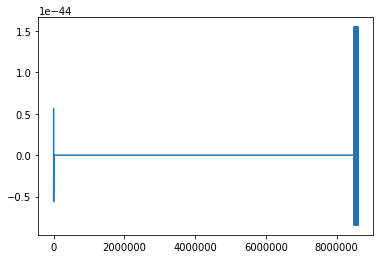

In [2]:
dim1 = 1050
dim2 = 20
start = 2
end = 7
# begin = 0 选取的能量段 (0最小 升序排序)  这个参数自己去改或者写成函数的参数
# 每一行有20个数据, dct后, 对第2到7位置的dct系数进行信息嵌入


modified_data = hide_text(text,'new_rewrite.wav', dim1, dim2, start, end)

text1, text2 = extract_palintext_from_file('new_rewrite_modified.wav', dim1,dim2, start, end)
print('********'*10)
print(text1)
print('********'*10)
print(text2)

# 查看差异： 
sig, rate = sf.read('new_rewrite_modified.wav', dtype='float32')
l, r = sig.T
plt.plot(range(len(r)), r-l)
plt.show()

In [36]:
# from matplotlib import image
# im = image.imread('aoligei.png')    # 读取图片，图片大小是80*80

# im = im[:, :, 0].reshape((-1, 8))
# msg = [int(''.join([str(j) for j in i]), 2) for i in im.astype(np.int16)]

# l = msg
# ext_bs = np.array([int(j) for i in l for j in '{0:0>8}'.format(bin(i)[2:])])    # 转变回二进制

# ewm = ext_bs.reshape((80, 80))  # 转变成80*80的图片矩阵
# image.imsave('alg.png', ewm)    # 保存图片